# Backblaze LSTM Training
This notebook creates a dataset that looks back X days. Also creates a sliding window approach for training LSTM. The premise is that we have modelled as a Regression problem.

This is what the vectors might look like with **window=3**.

```
X: [[x1, x2, x3], [x2, x3, x4], [x3, x4, x5]], Y: [30, 29, 28].
```

In this example, `y=30` corresponds to the RUL at `t=3 (x3)`.

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages

In [2]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

# Dataset Imports
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler

# DL Imports
from tensorflow import keras
from keras import layers
from keras.models import Sequential, save_model

## Load the Dataset

In [33]:
path = "/content/drive/MyDrive/ST4000DM000_full.csv"

df = pd.read_csv(path)
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df['date_converted'] = pd.to_datetime(df['date'])

In [34]:
display(df.info())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844986 entries, 0 to 844985
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   index           844986 non-null  int64         
 1   date            844986 non-null  object        
 2   serial_number   844986 non-null  object        
 3   model           844986 non-null  object        
 4   capacity_bytes  844986 non-null  int64         
 5   failure         844986 non-null  int64         
 6   smart_1_raw     844947 non-null  float64       
 7   smart_3_raw     837617 non-null  float64       
 8   smart_4_raw     837617 non-null  float64       
 9   smart_5_raw     844948 non-null  float64       
 10  smart_7_raw     837617 non-null  float64       
 11  smart_9_raw     844949 non-null  float64       
 12  smart_10_raw    837617 non-null  float64       
 13  smart_12_raw    837618 non-null  float64       
 14  smart_183_raw   837459 non-null  flo

None

,index,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,...,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_converted
0,0,2013-06-27,W300EE8B,ST4000DM000,4000787030016,0,182493888.0,NaN,NaN,32.0,...,NaN,NaN,25.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-27
1,1,2013-06-27,W300BHMT,ST4000DM000,4000787030016,0,178237928.0,NaN,NaN,0.0,...,NaN,NaN,25.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-27
2,2,2013-06-27,W300B0C2,ST4000DM000,4000787030016,0,29617432.0,NaN,NaN,0.0,...,NaN,NaN,23.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-27
3,3,2013-06-27,W300AR1D,ST4000DM000,4000787030016,0,124411736.0,NaN,NaN,24.0,...,NaN,NaN,24.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-27
4,4,2013-06-28,W300EE8B,ST4000DM000,4000787030016,0,64099568.0,NaN,NaN,32.0,...,NaN,NaN,24.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-28
5,5,2013-06-28,W300E0ZX,ST4000DM000,4000787030016,0,9064936.0,NaN,NaN,0.0,...,NaN,NaN,22.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-28
6,6,2013-06-28,W300DZ80,ST4000DM000,4000787030016,0,90977408.0,NaN,NaN,0.0,...,NaN,NaN,22.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-28
7,7,2013-06-28,W300D5W1,ST4000DM000,4000787030016,0,121099768.0,NaN,NaN,0.0,...,NaN,NaN,22.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-28
8,8,2013-06-28,W300D3ST,ST4000DM000,4000787030016,0,37221192.0,NaN,NaN,0.0,...,NaN,NaN,22.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-28
9,9,2013-06-28,W300D3RY,ST4000DM000,4000787030016,0,124778104.0,NaN,NaN,0.0,...,NaN,NaN,23.0,0.0,NaN,NaN,NaN,NaN,NaN,2013-06-28


## Fix NaNs in columns

Uses Linear Interpolation to write back NaN's columns

In [35]:
def fix_nans(data: pd.DataFrame) -> pd.DataFrame:
  df = data.copy()
  columns_with_nans = df.columns[df.isna().any()].tolist()

  df[columns_with_nans] = df[columns_with_nans].interpolate(method='linear', limit_direction='backward')
  assert ( len(df.columns[df.isna().any()]) == 0 )
  return df

In [36]:
df = fix_nans(df)

## Define Lookback Function

In [39]:
pd.options.mode.chained_assignment = None
def lookback(data: pd.DataFrame, lookback_days=25, window = None, verbose= False) -> pd.DataFrame:
  failures = data.loc[data['failure'] == 1]
  failures.sort_values(by='date_converted')
  display(failures.head(5))

  df = pd.DataFrame()

  failures_bar = tqdm(list(failures.iterrows()))

  for index, row in failures_bar:
      date = row['date_converted']
      lookback = [date - timedelta(days=days_ago) for days_ago in range(0, lookback_days)]
      rul = [days_ago for days_ago in reversed(range(0, lookback_days))]
      if verbose:
          print(f'Serial Number:{row["serial_number"]}, lookback:{lookback} \n')
      selection = data.loc[(data['date_converted'].isin(lookback)) & (data['serial_number'] == row['serial_number'])]
      if selection.shape[0] == lookback_days:
        selection['rul'] = rul
        selection_series = selection.squeeze()
        selection_slide = pd.DataFrame()

        # Implement Sliding Window
        if window is not None:
          for start_row in range(len(selection_series) - window + 1):
            selection_slide = pd.concat([selection_slide, selection_series[start_row:start_row + window]], axis=0, ignore_index=True)
          df = pd.concat([df, selection_slide], axis=0, ignore_index=True)
        else:
          df = pd.concat([df, selection], axis=0, ignore_index=True)
  return df

In [40]:
df = lookback(df, lookback_days=25)

,index,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,...,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_converted
74,74,2013-07-03,W300EE8B,ST4000DM000,4000787030016,1,49317992.0,0.0,4.0,32.0,...,4.0,1287.0,24.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-07-03
85,85,2013-07-03,W300AR1D,ST4000DM000,4000787030016,1,152391800.0,0.0,4.0,24.0,...,4.0,1287.0,24.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-07-03
127,127,2013-07-08,W300E0ZX,ST4000DM000,4000787030016,1,228664416.0,0.0,4.0,0.0,...,4.0,1287.0,23.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-07-08
157,157,2013-07-11,W300DZ80,ST4000DM000,4000787030016,1,88566432.0,0.0,4.0,0.0,...,4.0,1287.0,24.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-07-11
161,161,2013-07-11,W300CTKT,ST4000DM000,4000787030016,1,108748600.0,0.0,4.0,0.0,...,4.0,1287.0,23.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-07-11


100%|██████████| 4934/4934 [05:42<00:00, 14.39it/s]


In [41]:
df.head(10)

,index,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,...,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_converted,rul
0,767,2013-09-06,Z300GQ62,ST4000DM000,4000787030016,0,140666656.0,0.0,4.0,0.0,...,1287.0,23.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-06,24
1,771,2013-09-07,Z300GQ62,ST4000DM000,4000787030016,0,201173528.0,0.0,4.0,0.0,...,1287.0,23.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-07,23
2,775,2013-09-08,Z300GQ62,ST4000DM000,4000787030016,0,136700800.0,0.0,4.0,0.0,...,1287.0,22.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-08,22
3,779,2013-09-09,Z300GQ62,ST4000DM000,4000787030016,0,84029504.0,0.0,4.0,0.0,...,1287.0,22.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-09,21
4,783,2013-09-10,Z300GQ62,ST4000DM000,4000787030016,0,67606344.0,0.0,4.0,0.0,...,1287.0,22.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-10,20
5,787,2013-09-11,Z300GQ62,ST4000DM000,4000787030016,0,167244248.0,0.0,4.0,0.0,...,1287.0,23.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-11,19
6,791,2013-09-12,Z300GQ62,ST4000DM000,4000787030016,0,183330568.0,0.0,4.0,0.0,...,1287.0,22.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-12,18
7,795,2013-09-13,Z300GQ62,ST4000DM000,4000787030016,0,210716608.0,0.0,4.0,0.0,...,1287.0,22.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-13,17
8,800,2013-09-14,Z300GQ62,ST4000DM000,4000787030016,0,138628200.0,0.0,4.0,0.0,...,1287.0,23.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-14,16
9,813,2013-09-15,Z300GQ62,ST4000DM000,4000787030016,0,182747024.0,0.0,4.0,0.0,...,1287.0,23.0,0.0,0.0,0.0,2.545756e+14,3.000152e+09,2.051779e+10,2013-09-15,15


In [42]:
df.shape

(104425, 32)

## Create Dataset
Uses the window to create a sliding window, creates the dataset into X and Y and also splits to Train, Test and Validation sets.

Train = 0.8
Test = 0.2

In [43]:
def get_mask(df, start_year, end_year):
  mask = (df['date_converted'] >= f'{start_year}-1-1') & (df['date_converted'] <= f'{end_year}-12-31')
  return mask

In [55]:
def create_dataset(data, time_steps = 3):
  smart_features = [column for column in data.columns.tolist() if column.startswith('smart_')]
  smart_features = ['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw',
       'smart_9_raw', 'smart_188_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_241_raw', 'smart_242_raw']

  # Uncomment this line to try on restricted set of columns.
  # smart_features = ['smart_7_raw', 'smart_242_raw', 'smart_241_raw', 'smart_9_raw', 'smart_240_raw']

  target = 'rul'
  columns = smart_features + [target]

  X = data[smart_features].to_numpy()
  Y = data[[target]].to_numpy()

  scaler = MinMaxScaler((0, 255))

  X = scaler.fit_transform(X)

  assert (X.shape[0] == Y.shape[0])

  number_of_rows = X.shape[0]
  number_of_columns = len(smart_features)

  X = X.reshape((int(number_of_rows/time_steps), time_steps, number_of_columns))
  Y = Y.reshape((int(number_of_rows/time_steps), time_steps, 1))

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, shuffle=False)
  X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.10, shuffle=False)

  return scaler, (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)


In [56]:
_, (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = create_dataset(df, time_steps=25)

## Global variables

In [57]:
time_steps = 25
batch_size = 30

## Build Model

In [62]:
model = keras.Sequential()
model.add(layers.LSTM(50, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(layers.RepeatVector(time_steps))
model.add(layers.LSTM(50, activation='relu', return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss='mse', optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])

## Train

In [63]:
Y_train.shape

(2923, 25, 1)

In [64]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, Y_val))

Epoch 1/100
98/98 [==============================] - 7s 50ms/step - loss: 9099.8457 - root_mean_squared_error: 95.3931 - val_loss: 10934.7354 - val_root_mean_squared_error: 104.5693
Epoch 2/100
98/98 [==============================] - 5s 46ms/step - loss: 7241.3643 - root_mean_squared_error: 85.0962 - val_loss: 29767.5957 - val_root_mean_squared_error: 172.5329
Epoch 3/100
98/98 [==============================] - 4s 46ms/step - loss: 143366.2656 - root_mean_squared_error: 378.6374 - val_loss: 129488.0000 - val_root_mean_squared_error: 359.8444
Epoch 4/100
98/98 [==============================] - 5s 48ms/step - loss: 41133.4219 - root_mean_squared_error: 202.8137 - val_loss: 46530.8633 - val_root_mean_squared_error: 215.7101
Epoch 5/100
98/98 [==============================] - 4s 46ms/step - loss: 17635.6328 - root_mean_squared_error: 132.7992 - val_loss: 14410.6377 - val_root_mean_squared_error: 120.0443
Epoch 6/100
98/98 [==============================] - 5s 46ms/step - loss: 7060.238

## Report Scores

In [65]:
train_score = model.evaluate(X_train, Y_train)
print(f"Training: RMSE: {train_score[1]}, LogRMSE: {np.log10(train_score[1])}")
val_score = model.evaluate(X_val, Y_val)
print(f"Validation: RMSE: {val_score[1]}, LogRMSE: {np.log10(val_score[1])}")
test_score = model.evaluate(X_test, Y_test)
print(f"Testing: RMSE: {test_score[1]}, LogRMSE: {np.log10(test_score[1])}")

92/92 [==============================] - 1s 9ms/step - loss: 20.1699 - root_mean_squared_error: 4.4911
Training: RMSE: 4.491093158721924, LogRMSE: 0.6523520637243172
36/36 [==============================] - 0s 9ms/step - loss: 26.0569 - root_mean_squared_error: 5.1046
Validation: RMSE: 5.1045942306518555, LogRMSE: 0.7079612252882128
4/4 [==============================] - 0s 10ms/step - loss: 34.7578 - root_mean_squared_error: 5.8956
Testing: RMSE: 5.895575523376465, LogRMSE: 0.7705262071285415


## Visualize Plots

In [88]:
def plot(model, X_test, Y_test, samples_to_plot=30):
  Y_pred = model.predict(X_test)
  Y_true = Y_test
  plt.figure(figsize=(30, 10))
  plt.plot(range(samples_to_plot*time_steps), Y_true[: samples_to_plot].ravel(), color="tab:blue", ls="dashed", linewidth=5, label="True RUL")
  plt.plot(range(samples_to_plot*time_steps), Y_pred[: samples_to_plot].ravel(), color="tab:orange", linewidth=3, label="Predicted RUL")
  plt.legend(prop={'size': 22})
  plt.ylabel('RUL', fontsize=22)
  plt.xlabel('Test instances', fontsize=22)

  plt.yticks(fontsize=22)
  plt.xticks(fontsize=22)
  plt.show()

4/4 [==============================] - 0s 10ms/step


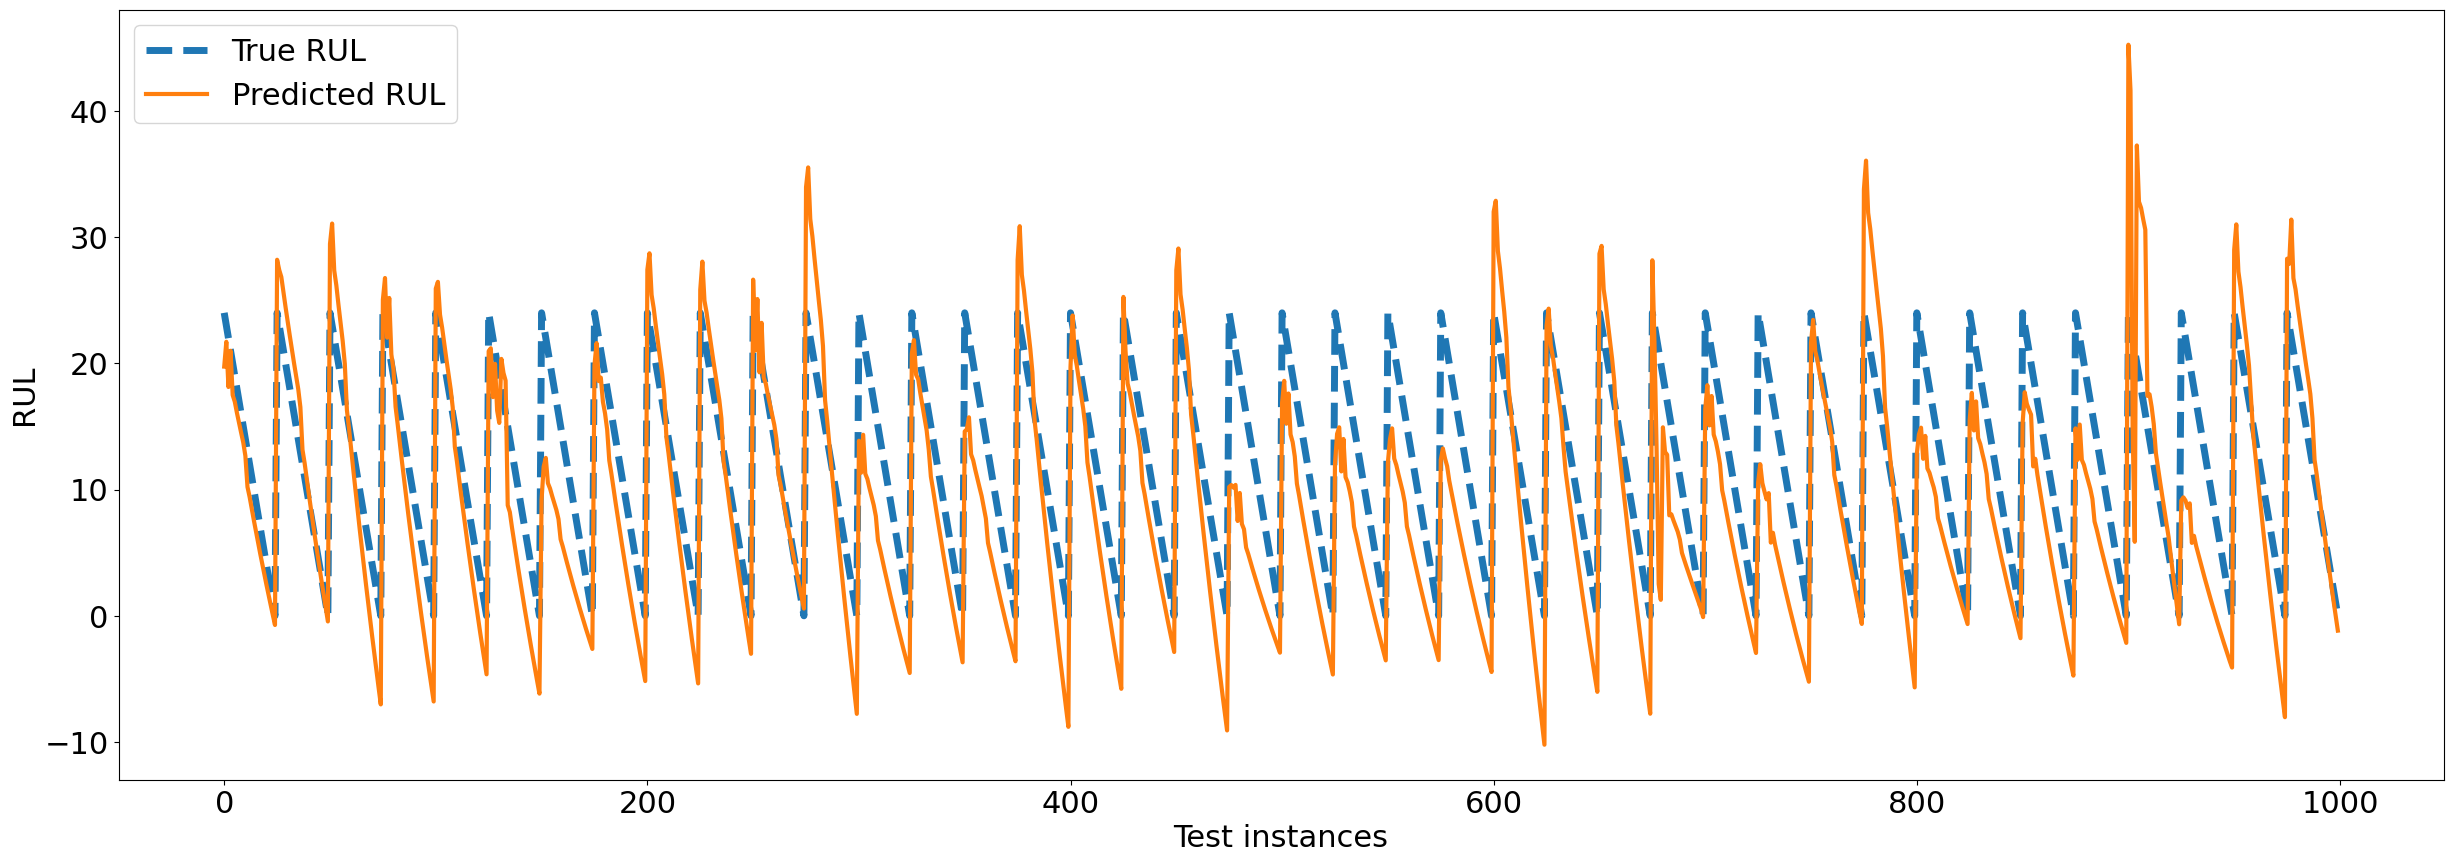

In [92]:
plot(model, X_test, Y_test, 40)

# Test on other Seagate Models

In [ ]:
other_seagate_drives = ["/content/drive/MyDrive/ST12000NM0007_full.csv", "/content/drive/MyDrive/ST3000DM001_full.csv", "/content/drive/MyDrive/ST8000DM002_full.csv", "/content/drive/MyDrive/ST8000NM0055_full.csv"]

def fix_nans(data: pd.DataFrame) -> pd.DataFrame:
  df = data.copy()
  columns_with_nans = df.columns[df.isna().any()].tolist()

  df[columns_with_nans] = df[columns_with_nans].interpolate(method='linear', limit_direction='backward')
  df = df.fillna(0)
  assert ( len(df.columns[df.isna().any()]) == 0 )
  return df


for drive in other_seagate_drives:
  odf = pd.read_csv(drive)
  odf.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
  odf['date_converted'] = pd.to_datetime(odf['date'])

  display(odf.head(3))

  odf = fix_nans(odf)
  odf = lookback(odf, lookback_days=time_steps)

  display(odf.shape)
  _, (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = create_dataset(odf, time_steps=time_steps)

  test_score = model.evaluate(X_test, Y_test)
  print(f"{drive} Testing: RMSE: {test_score[1]}, LogRMSE: {np.log10(test_score[1])}")
  plot(model, X_test, Y_test, 20)

  print("================================")
  print("")
